# Subset simulation (and Markov chain Monte-Carlo sampling)

Motivating example: Simply supported beam loaded by selfweight

Geometry:
- rectangular cross section
- $b$ ... width
- $h$ ... height
- $L$ ... length of beam

These parameters are fixed.

Material parameters:
- $E$ ... Young's modulus
- $\gamma$ ... specific weight

These parameters are random. We store them in vector $\mathbf{X} = [E, \gamma]^T$. The parameters are normally distributed
$$
\mathbf{X} \sim \mathcal{N}(\mathcal{\mu}_{\mathbf{x}}, \mathcal{C}_{\mathbf{x}})
$$
where the vector of mean values is 
$$
\mathbf{\mu}_{\mathbf{x}} =
\begin{bmatrix} 
\mu_{E} \\
\mu{\gamma}
\end{bmatrix}
$$
and the covariance matrix is 
$$
\mathbf{C}_{\mathbf{x}} =
\begin{bmatrix} 
\sigma_{E}^2 & \rho\sigma_{E}\sigma{\gamma} \\
\rho\sigma_{E}\sigma{\gamma} & \sigma_{\gamma}^2
\end{bmatrix}
$$

The parameters $\mu_E$, $\mu_\gamma$, $\sigma_E$, $\sigma_\gamma$ and $\rho$ are fixed and known.

The joint probability density function of the multivariate normal distribution is
$$
f(\mathbf{x})=
\frac{1}{\sqrt{(2\pi)^k\det(\mathbf{C}_{\mathbf{X}})}}
\exp\left(-\frac{1}{2} (\mathbf{x}-\mathbf{\mu}_{\mathbf{X}})^{T} \mathbf{C}_{\mathbf{X}}^{-1} ({\mathbf{x}}-\mathbf{\mu}_{\mathbf{X}})\right)
$$

where $k$ is the dimension of $x$.

Next, we assume that the failure occurs when deflection $W$ exceeds certain fixed limit $w_f$. Probability of failure is 
$$
P_f = \Pr(W>w_f)
$$
where $W$ is the random deflection calculated as
$$
W(X) = \frac{5}{384}\frac{qL^4}{EI}
$$
where
$q=\gamma A$ is the loading due to the selfweight, $A$ and $I$ are the area and the moment of inerita of the cross section, respecively.

Now the probability of failure can be written in the common form
$$
P_f = \Pr(g(X)<0)
$$
with the performance function being defined as 
$$
g(X) = w_f - \frac{5}{384}\frac{qL^4}{EI}
$$

## Crude MC
1. generate $\mathbf{x}_j$
2. compute $w(\mathbf{x}_j)$
3. count "failing" samples $w_j > w_f$
4. $P_f=\frac{n_f}{N}$

Rule of thumb $n_f>30$. 

When $P_f$ is small, it may require to generate a lot of samples and therefore a lot of $w(x)$ evaluations.

## Subset simulation

Recall 
$$
\Pr(A \cap B) = \Pr(A \mid B) \Pr(B)
$$

We can write 

$$
\Pr(W>w_f) = \Pr(W>w_f \mid W>w_{lim}) \Pr(W>w_{lim})
$$
because we chose some chosen value of deflection $w_{lim}$ so that $w_{lim}<w_f$ and therefore 
$$
W>w_f \subset W>w_{lim}
$$

Now we compute the two (small) probabilities independently and get the resulting (realy small) probability as their product.

Multiple levels
$$
\Pr(W>w_f) = \Pr(W>w_f \mid W>w_{2}) \Pr(W>w_{2} \mid W>w_{1}) \Pr(W>w_{1})
$$



In [26]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline


# Spruce wood
# Young modulus E [MPa], specific weight gamma [N/m3]
# X = [E, gamma]

# Mean values
mu_X = np.array([11e3, 6e3])

# Standard deviations
sig_x1 = 2e3
sig_x2 = 1e3

# Correlation coefficient
rho = 0.8

# Covariance matrix 
C_x = np.array([[sig_x1**2, rho*sig_x1*sig_x2],
                [rho*sig_x1*sig_x2, sig_x2**2]])

# Generate samples from multivariate normal.
samples_X = np.random.multivariate_normal(mu_X, C_x, 10000)

print('Generated samples of E and gamma:')
print(samples_X)

print('Average E and gamma:')
print(np.average(samples_X[:,0]), np.average(samples_X[:,1]))

Generated samples of E and gamma:
[[ 5834.58741648  4456.8684615 ]
 [ 8948.91868827  5497.57630105]
 [10360.47430414  5586.08389948]
 ...
 [11060.01268568  5380.45580775]
 [ 5989.72591681  4181.49732198]
 [10999.62609155  6058.46668089]]
Average E and gamma:
10995.236621229371 6000.25283149139


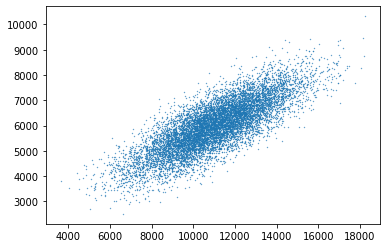

In [27]:
# Create scatter plot
scatter_X = plt.scatter(samples_X[:,0], samples_X[:,1], s=0.1)

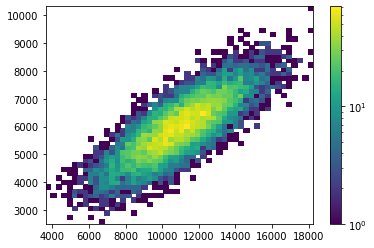

In [28]:
# Visualize data with 2d histogram
import matplotlib.colors as colors
fig, ax = plt.subplots() 
histogram_X = ax.hist2d(samples_X[:,0], samples_X[:,1], 50, norm=colors.LogNorm())
# Add color bar with frequencies.
plt.colorbar(histogram_X[3], ax=ax)

In [29]:
# Dimensions of beam
b = 0.005
h = 0.002
l = 1.0
A = b * h
I = 1 / 12 * b * h**3

# Deflection [m] of Kirchhoff model of simply supported beam.
def w_func(x):
    E = x[0] * 1e6 # Pa
    gamma = x[1] # N/m3
    q = A * gamma # N/m
    w = 5/384 * q * l**4 / E / I # m
    return w

print('Deflection for mean E and mean gamma:')
print(w_func(mu_X))

print('Deflection for average E and average gamma:')
print(w_func([np.average(samples_X[:,0]), np.average(samples_X[:,1])]))

Deflection for mean E and mean gamma:
0.021306818181818187
Deflection for average E and average gamma:
0.021316946992990318


In [30]:
samples_Y = np.array([w_func(x) for x in samples_X])
print('Samples of deflection:')
print(samples_Y)
print('Mean deflection:')
print(np.average(samples_Y))

Samples of deflection:
[0.02983869 0.02399721 0.02106143 ... 0.01900306 0.02726999 0.02151517]
Mean deflection:
0.02153356859559523


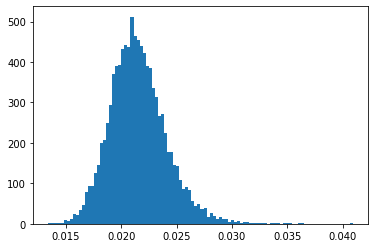

In [31]:
histogram_Y = plt.hist(samples_Y, bins=100)

In [32]:
w_limit = 0.025

# Conditional PDF
# Not PDF, does not integrate to 1.
def f_conditional(x):
    if w_func(x) > w_limit:
        return sp.stats.multivariate_normal.pdf(x, mu_X, C_x)
    else:
        return 0

# Initial sample    
x0 = [6e3, 5e3]
print(f_conditional(x0))
print(f_conditional(mu_X))


1.4530543174997753e-09
0


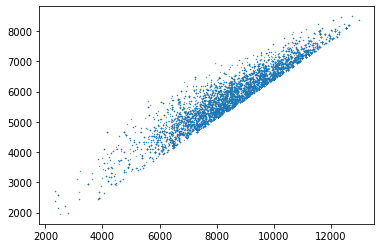

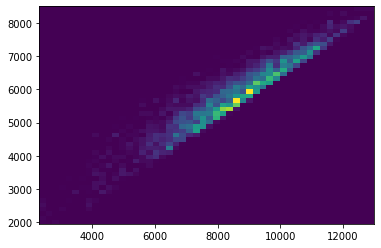

In [47]:
# Metropolis-Hastings
# -------------------

def get_candidate(x_current):
    # Trial (jumping) distribution
    mean = x_current
    c = 0.5
    cov = np.array([[(c*sig_x1)**2, 0.0],[0.0, (c*sig_x2)**2]])
    # Generate from proposal
    x_candidate = np.random.multivariate_normal(mean, cov, 1)[0]
    return x_candidate

def get_new_sample(x_candidate, x_current, f):
    f_can = f(x_candidate)
    f_cur = f(x_current)
    if f_can / f_cur > np.random.random():
        return x_candidate
    else:
        return x_current

samples_Xr = [x0]    
for i in range(10000):
    x_current = samples_Xr[-1]
    x_candidate = get_candidate(x_current)
    x_new = get_new_sample(x_candidate, x_current, f_conditional)
    samples_Xr.append(x_new)

samples_Xr = np.array(samples_Xr)

scatter_Xr = plt.scatter(samples_Xr[:,0], samples_Xr[:,1], s=0.1)
plt.show()
histgram_Xr = plt.hist2d(samples_Xr[:,0], samples_Xr[:,1], 50)
plt.show()

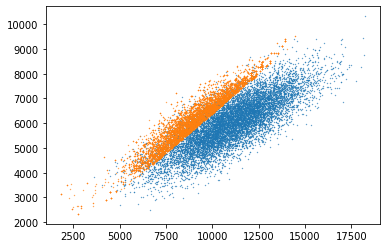

In [34]:
plt.scatter(samples_X[:,0], samples_X[:,1], s=0.1)
plt.scatter(samples_Xr[:,0], samples_Xr[:,1], s=0.1)

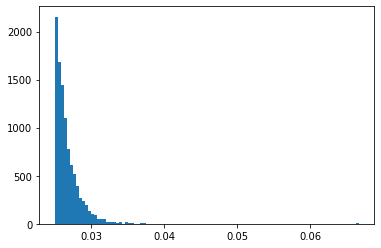

In [39]:
samples_Yr = np.array([w_func(x) for x in samples_Xr])
histogram_Yr = plt.hist(samples_Yr, 100)

In [40]:
num_1 = sum(w > w_limit for w in samples_Y)
p_w1 = num_1 / len(samples_Y)
print('p(w>{}):'.format(w_limit))
print('{} ({}/{})'.format(p_w1,num_1,len(samples_Y)))
print()

w_failure = 0.03
num_2 = sum(w > w_failure for w in samples_Yr)
p_w2_w1 = num_2 / len(samples_Yr)
print('p(w>{}|w>{}):'.format(w_failure, w_limit))
print('{} ({}/{})'.format(p_w2_w1,num_2,len(samples_Yr)))
print()

print('p(w>{}) = p(w>{}|w>{}) * p(w>{}):'.format(w_failure, w_failure, w_limit, w_limit))
print(p_w2_w1 * p_w1)


p(w>0.025):
0.0896 (896/10000)

p(w>0.03|w>0.025):
0.049295070492950704 (493/10001)

p(w>0.03) = p(w>0.03|w>0.025) * p(w>0.025):
0.004416838316168383


In [41]:
num_2_mc = sum(w > w_failure for w in samples_Y)
p_w2_mc = num_2_mc / len(samples_Y)
print('Brute force MC p(w>{}):'.format(w_failure))
print('{} ({}/{})'.format(p_w2_mc, num_2_mc, len(samples_Y)))
print(p_w2_mc)

Brute force MC p(w>0.03):
0.0051 (51/10000)
0.0051
